## Smart home device to automatically operating electronic appliances, predict the power consumption, and the cost.
#### Developed and deployed machine learning model using LSTM for prediction based on usage data.
- This model is based on the daily usage of lamps, and also can be implemented on any appliances.
- Data: humidity, weather, status, days, is_motion, light_intensity, time_minutes, temperature

Notes:

1) data_train (23961, 13)

2) data_test (6103, 13)
- 0.203%

3) 2000 epochs

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from sklearn import preprocessing
%matplotlib inline

import math
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


# Visualization

In [5]:
# load dataset one month (Tuesday, 17/03/2020 - Tuesday, 14/04/2020)
lamp1_data = pd.read_csv('full_data_switch1_1404_filled.csv')
value_visual = lamp1_data.values

In [19]:
lamp1_data.head(10)

,humidity,weather,device_id,created_at,switch_id,updated_at,id,status,days,is_motion,light_intensity,time_minutes,temperature
0,74.2000,7,1,3/17/2020 9:25,1,NaN,247,True,2,False,38.3333,565,30.3500
1,71.4000,7,1,3/17/2020 9:32,1,NaN,249,False,2,False,53.3333,572,31.0000
2,71.5000,7,1,3/17/2020 9:32,1,NaN,251,False,2,False,53.3333,572,31.0000
3,71.9375,7,1,3/17/2020 9:33,1,NaN,253,True,2,True,43.2292,573,31.0125
4,71.3000,7,1,3/17/2020 9:33,1,NaN,255,False,2,True,53.3712,573,31.0864
5,70.3125,7,1,3/17/2020 9:34,1,NaN,257,False,2,True,46.0417,574,31.1000
6,70.3727,7,1,3/17/2020 9:34,1,NaN,259,False,2,False,53.3333,574,31.1000
7,70.2333,7,1,3/17/2020 9:35,1,NaN,261,False,2,False,53.3333,575,31.1333
8,70.2333,7,1,3/17/2020 9:35,1,NaN,263,False,2,False,53.3333,575,31.1500
9,69.9125,7,1,3/17/2020 9:36,1,NaN,265,False,2,False,53.3333,576,31.2000


In [6]:
lamp1_data_sample = lamp1_data.query("id > 15251 & id < 15271")
lamp1_data_sample

,humidity,weather,device_id,created_at,switch_id,updated_at,id,status,days,is_motion,light_intensity,time_minutes,temperature
8481,72.7750,2,1,3/22/2020 18:22,1,NaN,15253,False,7,False,0.0,1102,30.500
8482,72.9000,2,1,3/22/2020 18:23,1,NaN,15255,False,7,False,0.0,1103,30.450
8483,72.9250,2,1,3/22/2020 18:24,1,NaN,15257,False,7,False,0.0,1104,30.475
8484,73.0500,2,1,3/22/2020 18:25,1,NaN,15259,False,7,False,0.0,1105,30.400
8485,73.2000,2,1,3/22/2020 18:26,1,NaN,15261,False,7,False,0.0,1106,30.400
8486,73.2250,2,1,3/22/2020 18:26,1,NaN,15263,False,7,False,0.0,1106,30.400
8487,73.3182,2,1,3/22/2020 18:27,1,NaN,15265,False,7,False,0.0,1107,30.400
8488,72.9000,2,1,3/22/2020 18:29,1,NaN,15267,False,7,False,0.0,1109,30.450
8489,72.9000,2,1,3/22/2020 18:30,1,NaN,15269,False,7,False,0.0,1110,30.440


In [20]:
lamp1_data.shape

(30064, 13)

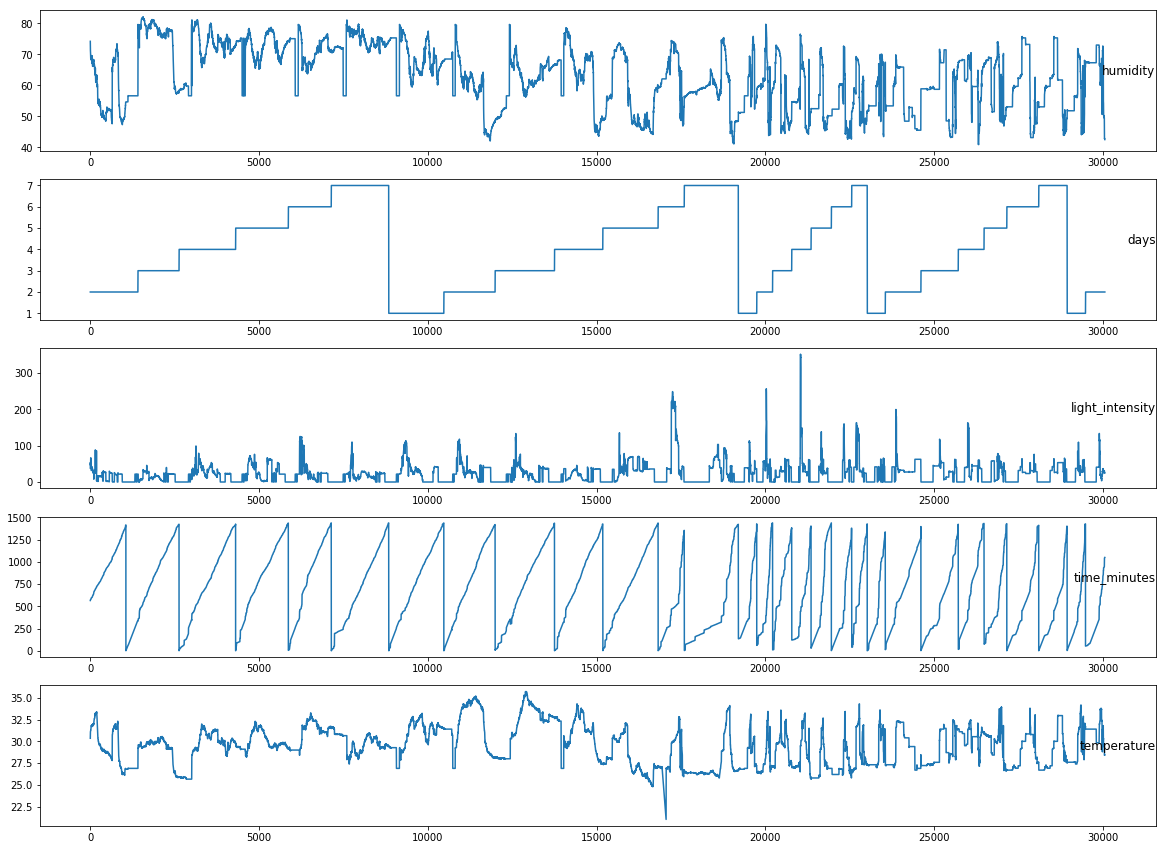

In [27]:
# columns to plot: 'humidity', 'weather', 'status', 'days', 'is_motion', 'light_intensity', 'time_minutes', 'temperature'
arrays = [0, 8, 10, 11, 12]
i = 1

# plot each column
plt.figure()
for array in arrays:
    plt.rcParams['figure.figsize'] = (20,10)
    plt.subplot(len(arrays), 1, i)
    plt.plot(value_visual[:, array])
    plt.title(lamp1_data.columns[array], y=0.5, loc='right')
    i += 1

# pyplot.plot(valuez[:, 7], marker='.', label="actual", linestyle = 'None')
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# pyplot.title(dataset.columns[7], y=0.5, loc='right')
plt.show()

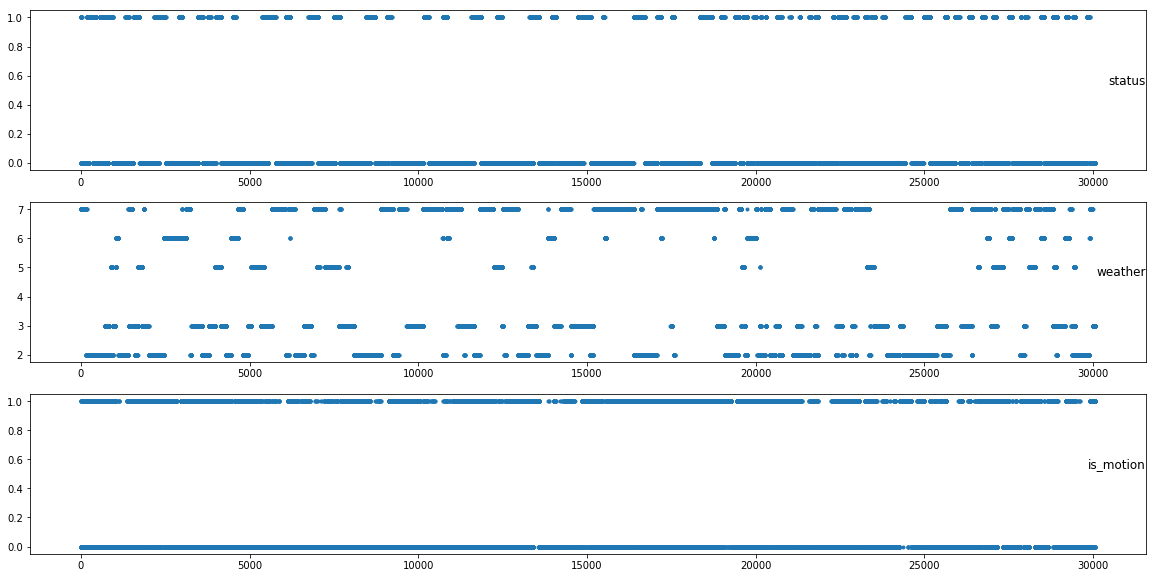

In [28]:
# specify columns to plot: 'humidity', 'weather', 'status', 'days', 'is_motion', 'light_intensity', 'time_minutes', 'temperature'
arrays = [7,1, 9]
i = 1

# plot each column
plt.figure()
for array in arrays:
    plt.rcParams['figure.figsize'] = (11,5)
    plt.subplot(len(groups), 1, i)
    plt.plot(value_visual[:, array], marker='.', linestyle = 'None')
    plt.title(lamp1_data.columns[array], y=0.5, loc='right')
    i += 1

# pyplot.plot(valuez[:, 7], marker='.', label="actual", linestyle = 'None')
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# pyplot.title(dataset.columns[7], y=0.5, loc='right')
plt.show()

In [7]:
lamp1_data = lamp1_data.set_index('created_at')
lamp1_data = lamp1_data[["status", "days", "weather", "temperature", "humidity", "light_intensity", "time_minutes", "is_motion"]]

In [54]:
lamp1_data.columns

Index(['status', 'days', 'weather', 'temperature', 'humidity',
       'light_intensity', 'time_minutes', 'is_motion'],
      dtype='object')

- status = 0
- days = 1
- weather = 2 
- temperature = 3
- humidity = 4
- light_intensity = 5 
- time_minutes = 6 
- is_motion = 7

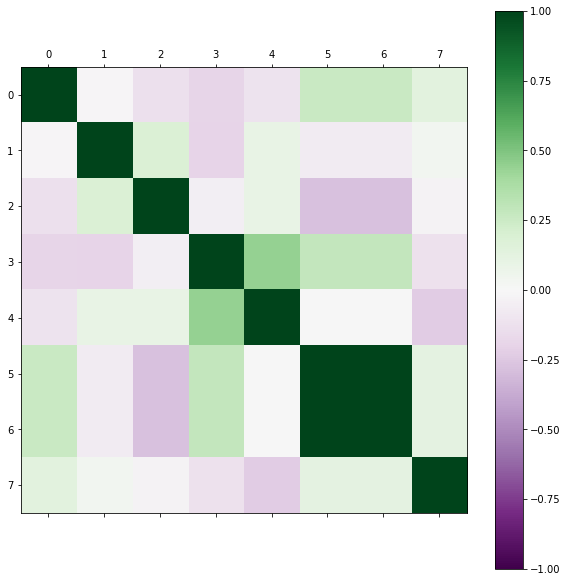

In [53]:
# Correlations among columns
plt.matshow(lamp1_data.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.rcParams['figure.figsize'] = (70,10)
plt.colorbar()
plt.show()

- Perfect: If the value is near ± 1, then it said to be a perfect correlation: as one variable increases, the other variable tends to also increase (if positive) or decrease (if negative).
- High degree: If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation.

In [3]:
lamp1_data.shape

(30064, 13)

## Save file

In [8]:
# Select only switch 1 (lamp_1)

# lamp1_data = lamp1_data.query("switch_id == 1")

# conditional query 
# lamp1_data = data.query("switch_id == 1 & column_name (==,>,<,etc) value")
# lamp1_data.to_csv('dataset.csv')

In [5]:
lamp1_data.head()

,status,days,weather,temperature,humidity,light_intensity,time_minutes,is_motion
created_at,,,,,,,,
3/17/2020 9:25,True,2,7,30.3500,74.2000,38.3333,565,False
3/17/2020 9:32,False,2,7,31.0000,71.4000,53.3333,572,False
3/17/2020 9:32,False,2,7,31.0000,71.5000,53.3333,572,False
3/17/2020 9:33,True,2,7,31.0125,71.9375,43.2292,573,True
3/17/2020 9:33,False,2,7,31.0864,71.3000,53.3712,573,True


In [8]:
lamp1_data.tail(10)

,status,days,weather,temperature,humidity,light_intensity,time_minutes,is_motion
created_at,,,,,,,,
4/14/2020 17:25,False,2,3,28.4000,42.8364,25.0,1045,False
4/14/2020 17:26,False,2,3,28.4000,42.8909,25.0,1046,True
4/14/2020 17:27,False,2,3,28.4000,42.9455,25.0,1047,False
4/14/2020 17:27,False,2,3,28.4000,42.8889,25.0,1047,True
4/14/2020 17:28,False,2,3,28.4000,42.8063,25.0,1048,True
4/14/2020 17:28,False,2,3,28.4000,42.7625,25.0,1048,False
4/14/2020 17:28,False,2,3,28.4000,42.7000,25.0,1048,True
4/14/2020 17:28,False,2,3,28.4000,42.7000,25.0,1048,True
4/14/2020 17:29,False,2,3,28.4111,42.6111,25.0,1049,True


In [7]:
lamp1_data.describe()

,days,weather,temperature,humidity,light_intensity,time_minutes
count,30064.000000,30064.000000,30064.000000,30064.000000,30064.000000,30064.000000
mean,4.033096,4.459287,29.484433,62.729989,22.801127,664.623736
std,1.950610,2.165354,2.301159,9.922898,29.471676,423.449058
min,1.000000,2.000000,21.050000,40.933300,0.000000,0.000000
25%,2.000000,2.000000,27.316700,54.700000,0.000000,268.000000
50%,4.000000,3.000000,29.500000,62.800000,21.666700,637.000000
75%,6.000000,7.000000,31.275000,71.300000,35.000000,1037.000000
max,7.000000,7.000000,35.700000,82.100000,351.667000,1439.000000


In [37]:
lamp1_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30064 entries, 3/17/2020 9:25 to 4/14/2020 17:30
Data columns (total 8 columns):
status             30064 non-null bool
days               30064 non-null int64
weather            30064 non-null int64
temperature        30064 non-null float64
humidity           30064 non-null float64
light_intensity    30064 non-null float64
time_minutes       30064 non-null int64
is_motion          30064 non-null bool
dtypes: bool(2), float64(3), int64(3)
memory usage: 1.7+ MB


## Time series to Supervised

#### Multivariate Time Series Forecasting with LSTMs in Keras by Jason Browlee
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [3]:
#Credit to Jason Brownlee

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Load Dataset

In [10]:
lamp1_data = pd.read_csv('dataset.csv')
lamp1_data = lamp1_data.set_index('created_at')
lamp1_data = lamp1_data[["status", "days", "weather", "temperature", "humidity", "light_intensity", "time_minutes", "is_motion"]]

## Scaling Data: MinMaxScaler

In [9]:
from sklearn.preprocessing import MinMaxScaler
## full data
values = lamp1_data.values

# integer encode direction
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## Framing Dataset to supervised

In [10]:
# frame as supervised learning
supervisedFrame = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
supervisedFrame.drop(supervisedFrame.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
supervisedFrame.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,1.0,0.166667,1.0,0.634812,0.808097,0.109005,0.392634,0.0,0.0
2,0.0,0.166667,1.0,0.679181,0.740081,0.151659,0.397498,0.0,0.0
3,0.0,0.166667,1.0,0.679181,0.742510,0.151659,0.397498,0.0,1.0
4,1.0,0.166667,1.0,0.680034,0.753138,0.122927,0.398193,1.0,0.0
5,0.0,0.166667,1.0,0.685079,0.737652,0.151766,0.398193,1.0,0.0


In [11]:
# split into train and test sets
values = supervisedFrame.values

# split 80:20
train_nums = lamp1_data.shape[0] * 0.797
train_nums = round(train_nums)
n_train_time = train_nums

train = values[:n_train_time, :] # 23961 == 3 minggu
test = values[n_train_time:, :] # 6102 == 1 minggu
##test = values[n_train_time:n_test_time, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# reshaped input into the 3D format for LSTMs, [samples, timesteps, features].

(23961, 1, 8) (23961,) (6102, 1, 8) (6102,)


- Data train dan test

1) Train: 23961 == 3 minggu 

2) Test: 6102 == 1 minggu

# Pre-Process ends here

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 23961 samples, validate on 6102 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
 - 3s - loss: 0.0704 - acc: 0.9151 - val_loss: 0.0076 - val_acc: 0.9934
Epoch 2/2000
 - 2s - loss: 0.0079 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 3/2000
 - 2s - loss: 0.0076 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 4/2000
 - 2s - loss: 0.0075 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 5/2000
 - 2s - loss: 0.0074 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 6/2000
 - 2s - loss: 0.0074 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 7/2000
 - 1s - loss: 0.0073 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 8/2000
 - 2s - loss: 0.0073 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 9/2000
 - 1s - loss: 0.0073 - acc: 0.9928 - val_loss: 0.0066 - val_acc: 0.9934
Epoch 10/2000
 - 2

 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 87/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 88/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 89/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 90/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 91/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 92/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 93/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 94/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 95/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 96/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 97/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 

Epoch 181/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 182/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 183/2000
 - 2s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 184/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 185/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 186/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 187/2000
 - 2s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 188/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 189/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 190/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 191/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 192/2000
 - 1s - loss: 0.0072 - acc: 

 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 276/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 277/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 278/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 279/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 280/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 281/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 282/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 283/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 284/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 285/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 286/2000
 - 1s - loss: 0.0072 - acc: 0.9928 - val_lo

Epoch 370/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 371/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 372/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 373/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 374/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 375/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 376/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 377/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 378/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 379/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 380/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0067 - val_acc: 0.9934
Epoch 381/2000
 - 1s - loss: 0.0071 - acc: 

 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 465/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 466/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 467/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 468/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 469/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 470/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 471/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 472/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 473/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 474/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 475/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_lo

Epoch 559/2000
 - 2s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 560/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 561/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 562/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 563/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 564/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 565/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 566/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 567/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 568/2000
 - 1s - loss: 0.0071 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 569/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 570/2000
 - 1s - loss: 0.0071 - acc: 

 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 654/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 655/2000
 - 2s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 656/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 657/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 658/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 659/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 660/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 661/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 662/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 663/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0068 - val_acc: 0.9934
Epoch 664/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_lo

Epoch 748/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 749/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 750/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 751/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 752/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 753/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 754/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 755/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 756/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 757/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 758/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 759/2000
 - 1s - loss: 0.0070 - acc: 

 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 843/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 844/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 845/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0070 - val_acc: 0.9934
Epoch 846/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 847/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0070 - val_acc: 0.9934
Epoch 848/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 849/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0070 - val_acc: 0.9934
Epoch 850/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 851/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0070 - val_acc: 0.9934
Epoch 852/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0069 - val_acc: 0.9934
Epoch 853/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_lo

Epoch 937/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 938/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0070 - val_acc: 0.9934
Epoch 939/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 940/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0070 - val_acc: 0.9934
Epoch 941/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 942/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 943/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0070 - val_acc: 0.9934
Epoch 944/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 945/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 946/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 947/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 948/2000
 - 1s - loss: 0.0070 - acc: 

Epoch 1031/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 1032/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 1033/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 1034/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1035/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 1036/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 1037/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1038/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 1039/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1040/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1041/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0071 - val_acc: 0.9934
Epoch 1042/2000
 - 1s - loss: 0.

 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1125/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1126/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1127/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0073 - val_acc: 0.9934
Epoch 1128/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1129/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1130/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1131/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1132/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1133/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1134/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0072 - val_acc: 0.9934
Epoch 1135/2000
 - 1s - loss: 0.0069 - acc: 0.99

Epoch 1218/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0073 - val_acc: 0.9934
Epoch 1219/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1220/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0073 - val_acc: 0.9934
Epoch 1221/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1222/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0073 - val_acc: 0.9934
Epoch 1223/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0073 - val_acc: 0.9934
Epoch 1224/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1225/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0073 - val_acc: 0.9934
Epoch 1226/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0073 - val_acc: 0.9934
Epoch 1227/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0073 - val_acc: 0.9934
Epoch 1228/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0073 - val_acc: 0.9934
Epoch 1229/2000
 - 1s - loss: 0.

 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0073 - val_acc: 0.9934
Epoch 1312/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1313/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1314/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1315/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1316/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1317/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1318/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1319/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1320/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1321/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1322/2000
 - 1s - loss: 0.0069 - acc: 0.99

Epoch 1405/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1406/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1407/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1408/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1409/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1410/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0076 - val_acc: 0.9934
Epoch 1411/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1412/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1413/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0074 - val_acc: 0.9934
Epoch 1414/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1415/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1416/2000
 - 1s - loss: 0.

 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0076 - val_acc: 0.9934
Epoch 1499/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1500/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1501/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0076 - val_acc: 0.9934
Epoch 1502/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0076 - val_acc: 0.9934
Epoch 1503/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1504/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1505/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0076 - val_acc: 0.9934
Epoch 1506/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0078 - val_acc: 0.9934
Epoch 1507/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1508/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1509/2000
 - 1s - loss: 0.0069 - acc: 0.99

Epoch 1592/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0076 - val_acc: 0.9934
Epoch 1593/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1594/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0078 - val_acc: 0.9934
Epoch 1595/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1596/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1597/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1598/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0078 - val_acc: 0.9934
Epoch 1599/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1600/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9934
Epoch 1601/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1602/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1603/2000
 - 1s - loss: 0.

 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0078 - val_acc: 0.9934
Epoch 1686/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0078 - val_acc: 0.9934
Epoch 1687/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0078 - val_acc: 0.9934
Epoch 1688/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0078 - val_acc: 0.9934
Epoch 1689/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0079 - val_acc: 0.9934
Epoch 1690/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0079 - val_acc: 0.9934
Epoch 1691/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0076 - val_acc: 0.9934
Epoch 1692/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1693/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0078 - val_acc: 0.9934
Epoch 1694/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0078 - val_acc: 0.9934
Epoch 1695/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0076 - val_acc: 0.9934
Epoch 1696/2000
 - 1s - loss: 0.0068 - acc: 0.99

Epoch 1779/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0080 - val_acc: 0.9934
Epoch 1780/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0079 - val_acc: 0.9934
Epoch 1781/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0081 - val_acc: 0.9934
Epoch 1782/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0079 - val_acc: 0.9934
Epoch 1783/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0080 - val_acc: 0.9934
Epoch 1784/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0080 - val_acc: 0.9934
Epoch 1785/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1786/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0080 - val_acc: 0.9934
Epoch 1787/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0081 - val_acc: 0.9934
Epoch 1788/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0080 - val_acc: 0.9934
Epoch 1789/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0077 - val_acc: 0.9934
Epoch 1790/2000
 - 1s - loss: 0.

 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0079 - val_acc: 0.9934
Epoch 1873/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0082 - val_acc: 0.9934
Epoch 1874/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0082 - val_acc: 0.9934
Epoch 1875/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0081 - val_acc: 0.9934
Epoch 1876/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0079 - val_acc: 0.9934
Epoch 1877/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0081 - val_acc: 0.9934
Epoch 1878/2000
 - 1s - loss: 0.0070 - acc: 0.9928 - val_loss: 0.0082 - val_acc: 0.9934
Epoch 1879/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0082 - val_acc: 0.9934
Epoch 1880/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0079 - val_acc: 0.9934
Epoch 1881/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0081 - val_acc: 0.9934
Epoch 1882/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0082 - val_acc: 0.9934
Epoch 1883/2000
 - 1s - loss: 0.0069 - acc: 0.99

Epoch 1966/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0082 - val_acc: 0.9934
Epoch 1967/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0083 - val_acc: 0.9934
Epoch 1968/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0085 - val_acc: 0.9934
Epoch 1969/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0082 - val_acc: 0.9934
Epoch 1970/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0082 - val_acc: 0.9934
Epoch 1971/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0080 - val_acc: 0.9934
Epoch 1972/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0083 - val_acc: 0.9934
Epoch 1973/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0084 - val_acc: 0.9934
Epoch 1974/2000
 - 1s - loss: 0.0069 - acc: 0.9928 - val_loss: 0.0082 - val_acc: 0.9934
Epoch 1975/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0082 - val_acc: 0.9934
Epoch 1976/2000
 - 1s - loss: 0.0068 - acc: 0.9928 - val_loss: 0.0083 - val_acc: 0.9934
Epoch 1977/2000
 - 1s - loss: 0.

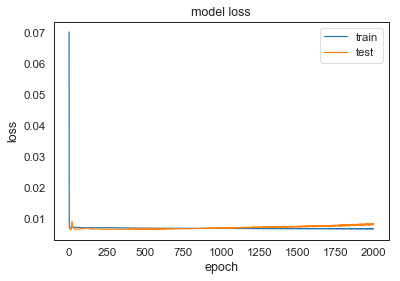

Test RMSE: 0.091


In [14]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

# fit network
history = model.fit(train_X, train_y, epochs=2000, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 8))

# # invert scaling for forecast 
invert_pred = np.concatenate((yhat, test_X[:, 1:]), axis=1)
invert_pred = scaler.inverse_transform(invert_pred)

# prediction data
invert_pred = invert_pred[:,0]

# # invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
invert_act = np.concatenate((test_y, test_X[:, 1:]), axis=1)
invert_act = scaler.inverse_transform(invert_act)

# actual data
invert_act = invert_act[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(invert_act, invert_pred))
print('Test RMSE: %.3f' % rmse)

In [15]:
yhat.shape

(6102, 1)

In [16]:
RMSE: 0.091
model.save('LSTM_final_model.h5py')

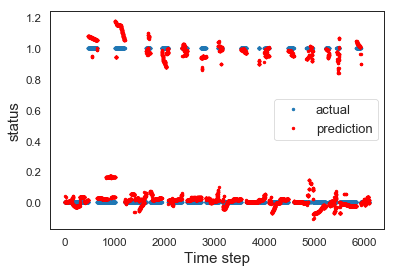

In [17]:
## time steps, every step is one hour
## this is the predictions in one months. (january) 

aa= [x for x in range(6102)]
plt.plot(aa, invert_act[:6102], marker='.', label="actual", linestyle = 'None')
plt.plot(aa, invert_pred[:6102],marker='.', color='r', label="prediction", linestyle = 'None')
plt.ylabel('status', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=13)
plt.show()

In [42]:
invert_act.shape

(6102,)

In [43]:
invert_pred.shape

(6102,)

### Check time

In [44]:
# actual: around 20 status true -> lamp on
invert_act[5000]

0.0

In [45]:
# prediction: around 20 status true -> lamp on
int(invert_pred[5000].round())

0

DONE

## Demo implementation model ML

In [59]:
lamp1_data = pd.read_csv('full_data_switch1_1204_1Day.csv')
lamp1_data = lamp1_data.set_index('created_at')
lamp1_data = lamp1_data[["status", "days", "weather", "temperature", "humidity", "light_intensity", "time_minutes", "is_motion"]]

In [60]:
lamp1_data.head()

,status,days,weather,temperature,humidity,light_intensity,time_minutes,is_motion
created_at,,,,,,,,
4/12/2020 0:00,False,7,5,26.7500,52.8667,0.0000,0,False
4/12/2020 0:00,False,7,5,26.7500,52.8667,0.0000,1,False
4/12/2020 0:00,False,7,5,26.7000,53.1000,0.0000,2,True
4/12/2020 0:00,False,7,5,26.7000,53.1000,0.0000,3,True
4/12/2020 0:00,False,7,5,26.7000,53.1000,0.0000,4,True


In [61]:
lamp1_data.tail()

,status,days,weather,temperature,humidity,light_intensity,time_minutes,is_motion
created_at,,,,,,,,
4/12/2020 23:22,False,7,3,27.7000,49.3500,0.0000,1435,False
4/12/2020 23:22,False,7,3,27.7000,49.3500,0.0000,1436,False
4/12/2020 23:22,False,7,3,27.7000,49.3500,0.0000,1437,False
4/12/2020 23:22,False,7,3,27.7000,49.3500,0.0000,1438,False
4/12/2020 23:22,False,7,3,27.7000,49.3500,0.0000,1439,False


In [62]:
from keras.models import load_model
loaded_model = load_model('model_LSTM_3_train_1_test.h5py')

In [63]:
from sklearn.preprocessing import MinMaxScaler
## full data
values = lamp1_data.values

# integer encode direction
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [64]:
# frame as supervised learning
supervisedFrame = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
supervisedFrame.drop(supervisedFrame.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
supervisedFrame.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.0000,0.0000,0.6000,0.0079,0.2815,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.6000,0.0079,0.2815,0.0000,0.0007,0.0000,0.0000
3,0.0000,0.0000,0.6000,0.0000,0.2889,0.0000,0.0014,1.0000,0.0000
4,0.0000,0.0000,0.6000,0.0000,0.2889,0.0000,0.0021,1.0000,0.0000
5,0.0000,0.0000,0.6000,0.0000,0.2889,0.0000,0.0028,1.0000,0.0000


In [65]:
# select features (predictor)
values = supervisedFrame.values
values = values[:, :-1]
values_input = values.reshape((values.shape[0], 1, values.shape[1]))

In [66]:
values_input.shape

(1398, 1, 8)

In [67]:
result = loaded_model.predict(values_input)

In [68]:
result.shape

(1398, 1)

In [69]:
result = result.round() #untuk dibulatkan ke 0 dan 1 (True / False)

In [70]:
hasil = result[:,-1]

In [71]:
hasil.shape

(1398,)

In [72]:
hasil

array([ 0.,  0.,  0., ..., -0., -0., -0.], dtype=float32)

In [36]:
########################################### End Here ##########################################################

PLAYGROUND

In [103]:
def dataPreparation(data):
    #load raw data 
    dataset = pd.read_csv(data)
    
    #use initial value for scaling 
    datatemp_ = pd.DataFrame({"humidity":[40.0,91.0, 50.0], 
                        "weather":[2.0, 7.0, 5.0],
                        "device_id":[0, 1.0, 1.0],
                        "created_at":[0, 1.0, 1.0],
                        "switch_id":[1, 1, 1],
                        "updated_at":[0, 1, 1],
                        "id":[1, 2, 1],
                        "status":[0, 0, 1],
                        "days":[1, 7, 2],
                        "is_motion":[0, 1, 1],
                        "light_intensity":[0.0,352.0,1.0],
                        "time_minutes":[0,1439,4],
                        "temperature":[23.0,36.0,25.0],
                        })
    
    dataset = dataset.append(datatemp_)
    
    #select switch_id = 1
    lamp1_data = dataset.query("switch_id == 1")

    #timestamp to pandas index
    lamp1_data = lamp1_data.set_index('created_at')

    #reorder column
    lamp1_data = lamp1_data[["status", "days", "weather", "temperature", "humidity", "light_intensity", "time_minutes", "is_motion"]]
    
    
    # full data
    values = lamp1_data.values

    # integer encode direction
    # make all data to float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    
    # frame as supervised learning
    supervisedFrame = series_to_supervised(scaled, 1, 1)
    # drop columns we don't want to predict
    supervisedFrame.drop(supervisedFrame.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

    
    # select features (predictor)
    values = supervisedFrame.values
    values = values[:, :-1]
    values_input = values.reshape((values.shape[0], 1, values.shape[1]))
    
    return values_input

# Using load model

In [2]:
from tensorflow.keras.models import load_model
loaded_model = load_model('LSTM_final_model.h5py')

In [3]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (UnifiedLSTM)           (None, 100)               43600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


In [4]:
# load dataset switch lampu (manual)
lamp1_implement = pd.read_csv('data_implementasi_switch1.csv')
lamp2_implement = pd.read_csv('data_implementasi_switch2.csv')

In [6]:
total_min_temp1 = lamp1_implement.status.sum()
total_kwh1 = ((total_min_temp1 / 60) * 3 ) / 1000 
cost1 = total_kwh1 * 1467.26
cost1

1191.048305

In [7]:
total_min_temp1

16235

In [11]:
total_min_temp1 / 60

270.5833333333333

In [8]:
total_min_temp2 = lamp2_implement.status.sum()
total_kwh2 = ((total_min_temp2 / 60) * 3 ) / 1000 
cost2 = total_kwh2 * 1467.26
cost2

757.7664270000001

In [12]:
total_min_temp2

10329

In [13]:
total_min_temp2 / 60

172.15

In [10]:
percentage = 1 - (cost2 / cost1)
percentage

0.3637819525716045

# Implementation

### Pre-process

In [23]:
from tensorflow.keras.models import load_model
loaded_model = load_model('LSTM_final_model.h5py')

#################################################
from sklearn.preprocessing import MinMaxScaler
lamp2_implement = pd.read_csv('data_implementasi_switch2.csv')
lamp2_implement = lamp2_implement.set_index('created_at')
lamp2_implement = lamp2_implement[["status", "days", "weather", "temperature", "humidity", "light_intensity", "time_minutes", 'is_motion']]
actual_status = lamp2_implement.status

## full data
values = lamp2_implement.values

# integer encode direction
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#################################################
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

# select features (predictor)
values = reframed.values
values = values[:, :-1]
values_input = values.reshape((values.shape[0], 1, values.shape[1]))

In [24]:
print(lamp2_implement.shape)
print(values_input.shape)
print(actual_status.shape)

(40107, 8)
(40103, 1, 8)
(40107,)


### Predict

In [25]:
# from sklearn.metrics import mean_squared_error

# make a prediction
yhat = loaded_model.predict(values_input)
values_input = values_input.reshape((values_input.shape[0], 8))

# invert scaling for forecast 
invert_pred = np.concatenate((yhat, values_input[:, 1:]), axis=1)
invert_pred = scaler.inverse_transform(invert_pred)

# prediction data
invert_pred = invert_pred[:,0]

# actual data: actual_status

# calculate RMSE
# rmse = np.sqrt(mean_squared_error(actual_status, invert_pred))
# print('Test RMSE: %.3f' % rmse)

- data from 2nd day (start 12pm)

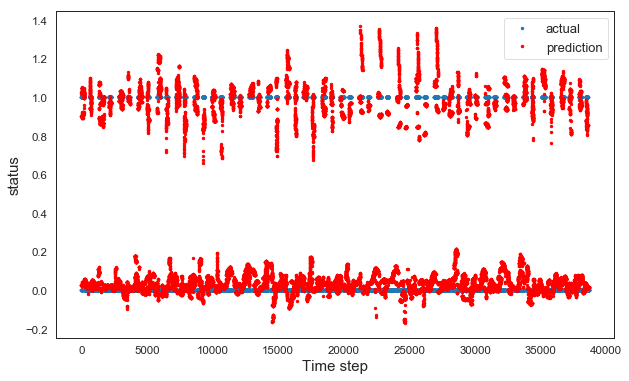

In [55]:
aa= [x for x in range(38660)]
plt.rcParams['figure.figsize'] = (10,6) #(lebar, tinggi) ####### BUAT RESIZE #######
plt.plot(aa, actual_status[1440:40100], marker='.', label="actual", linestyle = 'None')
plt.plot(aa, invert_pred[1440:40100], marker='.', color='r', label="prediction", linestyle = 'None')
plt.ylabel('status', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=13)

plt.show()

- data from day 2-3 (start 12pm)

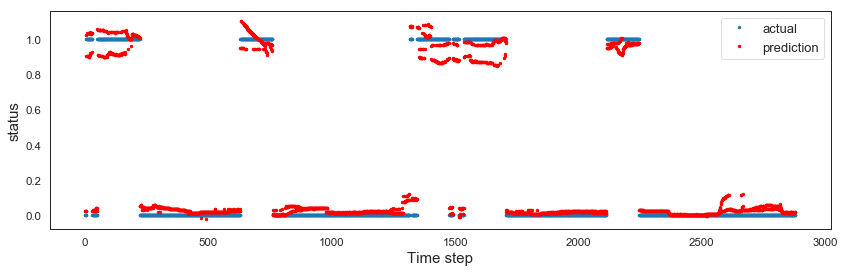

In [53]:
aa= [x for x in range(2880)]
plt.rcParams['figure.figsize'] = (14,4) #(lebar, tinggi) ####### BUAT RESIZE #######
plt.plot(aa, actual_status[1440:4320], marker='.', label="actual", linestyle = 'None')
plt.plot(aa, invert_pred[1440:4320], marker='.', color='r', label="prediction", linestyle = 'None')
plt.ylabel('status', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=13)

plt.show()

- 5/18/2020: 16000
- 5/20/2020: 20175
- 4175 data for 3 days (start 00am)

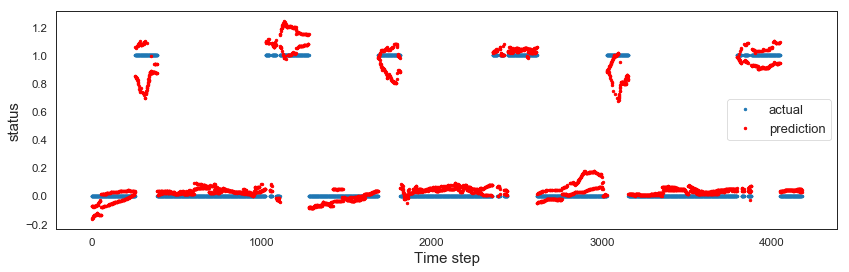

In [46]:
aa= [x for x in range(4175)]
plt.rcParams['figure.figsize'] = (14,4) #(lebar, tinggi) ####### BUAT RESIZE #######
plt.plot(aa, actual_status[16000:20175], marker='.', label="actual", linestyle = 'None')
plt.plot(aa, invert_pred[16000:20175], marker='.', color='r', label="prediction", linestyle = 'None')
plt.ylabel('status', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=13)

plt.show()

In [34]:
invert_pred.min()

-0.16685721

In [36]:
invert_pred.max()

1.367897

In [50]:
1440 * 3

4320

In [51]:
4320 - 1440

2880

In [54]:
40100 - 1440

38660